In [1]:
%cd ..

/Users/danorel/Workspace/Education/Self-Education/Programming/AI/MuJoCo/rlab


In [2]:
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import mediapy as media
import numpy as np
import time

In [3]:
m = mujoco.MjModel.from_xml_path("tutorial/models/box_and_square_free_joint.xml")
d = mujoco.MjData(m)

In [4]:
renderer = mujoco.Renderer(m, 240, 320)

In [5]:
fps = 30
slowmode = 8 # 1/8 from real time
n_frames = 200

frames = []

options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

m.vis.scale.contactwidth = 0.1
m.vis.scale.contactheight = 0.05
m.vis.scale.forcewidth = 0.05
m.vis.map.force = 0.2

mujoco.mj_resetData(m, d)
d.qvel[3:6] = 2 * np.random.randn(3)

for i in range(n_frames):
    while d.time * fps * slowmode < i:
        mujoco.mj_step(m, d)
    renderer.update_scene(d, "track", options)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=fps)

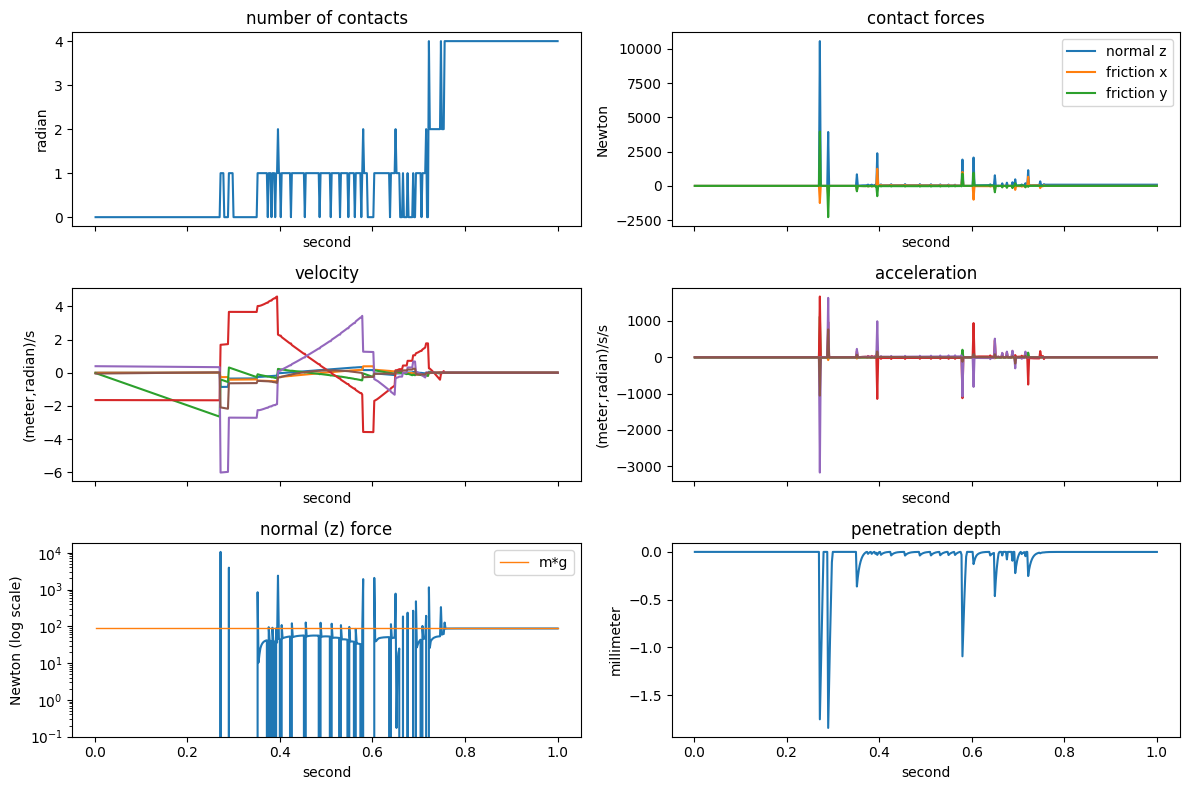

In [6]:
n_steps = 500

accelerations = np.zeros((n_steps, m.nv))
forces = np.zeros((n_steps, 3))
ncons = np.zeros(n_steps)
penetrations = np.zeros(n_steps)
timevals = np.zeros(n_steps)
velocities = np.zeros((n_steps, m.nv))
forcetorque = np.zeros(6)

mujoco.mj_resetData(m, d)
d.qvel[3:6] = 2 * np.random.randn(3)

_, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

for i in range(n_steps):
    mujoco.mj_step(m, d)

    timevals[i] = d.time
    ncons[i] = d.ncon
    velocities[i] = d.qvel[:]
    accelerations[i] = d.qacc[:]

    for j, c in enumerate(d.contact):
        mujoco.mj_contactForce(m, d, j, forcetorque)
        forces[i] += forcetorque[0:3]
        penetrations[i] = min(penetrations[i], c.dist)

ax[0, 0].plot(timevals, ncons)
ax[0, 0].set_title('number of contacts')
ax[0, 0].set_ylabel('radian')
ax[0, 0].set_xlabel('second')

lines = ax[0, 1].plot(timevals, forces)
ax[0, 1].legend(iter(lines), ('normal z', 'friction x', 'friction y'));
ax[0, 1].set_title('contact forces')
ax[0, 1].set_ylabel('Newton')
ax[0, 1].set_xlabel('second')

ax[1, 0].plot(timevals, velocities)
ax[1, 0].set_title('velocity')
ax[1, 0].set_ylabel('(meter,radian)/s')
ax[1, 0].set_xlabel('second')

ax[1, 1].plot(timevals, accelerations)
ax[1, 1].set_title('acceleration')
ax[1, 1].set_ylabel('(meter,radian)/s/s')
ax[1, 1].set_xlabel('second')

ax[2, 0].plot(timevals, forces[:, 0])
ax[2, 0].set_yscale('log')
ax[2, 0].set_title('normal (z) force')
ax[2, 0].set_ylabel('Newton (log scale)')
ax[2, 0].set_xlabel('second')
z_gravity = -m.opt.gravity[2]
mg = m.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[2, 0].plot(timevals, np.ones(n_steps) * mg, label='m*g', linewidth=1)
ax[2, 0].legend()

ax[2, 1].plot(timevals, 1000 * penetrations)
ax[2, 1].set_title('penetration depth')
ax[2, 1].set_ylabel('millimeter')
ax[2, 1].set_xlabel('second')

plt.tight_layout()